In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')

In [2]:
import numpy as np
import pandas as pd
from os import listdir
import random
from PIL import Image
from minisom import MiniSom
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, HDBSCAN
import umap
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

In [3]:
### Loading the features by name
features_by_name = pd.read_parquet(base_directory + 'original_features_by_name.parquet')
# features_by_name = features_by_name.dropna(axis=0)
# features_by_name = features_by_name.query("type in @qso_types")
### Sampling to save memory
# features_by_name = features_by_name.sample(frac=0.1)

### Loading the features by OID
# features_by_oid = pd.read_parquet(base_directory + 'original_features_by_oid.parquet')
# features_by_oid = features_by_oid.dropna(axis=0)
# features_by_oid = features_by_oid.query("type in @qso_types")
### Sampling to save memory
# features_by_oid = features_by_oid.sample(frac=0.1)

In [4]:
feature_names = ['z', 'T2020_sigma2', 'mhps_ratio', 'mhps_low', 'mhps_high', 'Amplitude', 'AndersonDarling', 'Autocor_length',
                 'Beyond1Std', 'Con', 'Eta_e', 'Gskew', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
                 'PercentAmplitude', 'Q31', 'PeriodLS_v2', 'Period_fit_v2', 'Psi_CS_v2', 'Psi_eta_v2', 'Rcs', 'Skew', 'SmallKurtosis',
                 'Std', 'StetsonK', 'Pvar', 'ExcessVar', 'GP_DRW_sigma', 'GP_DRW_tau', 'SF_ML_amplitude', 'SF_ML_gamma', 'IAR_phi',
                 'LinearTrend', 'Harmonics_mag_1', 'Harmonics_mag_2', 'Harmonics_mag_3', 'Harmonics_mag_4', 'Harmonics_mag_5',
                 'Harmonics_mag_6', 'Harmonics_mag_7', 'Harmonics_phase_2', 'Harmonics_phase_3', 'Harmonics_phase_4', 'Harmonics_phase_5',
                 'Harmonics_phase_6', 'Harmonics_phase_7', 'Harmonics_mse', 'mhps_non_zero', 'mhps_PN_flag']

band_feature_names = ['z'] + ['r_' + feature_name for feature_name in feature_names[1:]] + ['g_' + feature_name for feature_name in feature_names[1:]]
band_label_names = {i: feature_name for i, feature_name in enumerate(band_feature_names)}

In [5]:
### How big is data?
data_df = features_by_name[['type'] + band_feature_names]

print(f'There are {len(data_df)} rows in data right now.\n')
data_df['type'].value_counts()

There are 32187 rows in data right now.



type
Q     19613
A      3598
QX     2429
AX     1489
QR     1283
      ...  
NX        2
KX        1
K         1
KR        1
NR        1
Name: count, Length: 29, dtype: int64

In [6]:
feature_ranges = {
    'T2020_sigma2': (0, 0.2),
    'mhps_ratio': (0, 1000),
    'mhps_low': (0, 2),
    'mhps_high': (0, 0.2),
    'SmallKurtosis': (0, 20),
    'ExcessVar': (0, 0.0004),
    'GP_DRW_sigma': (0, 0.3),
    'GP_DRW_tau': (0, 4000),
    'SF_ML_amplitude': (0, 2),
    'LinearTrend': (-0.003, 0.003),
    'Harmonics_mag_1': (0, 400),
    'Harmonics_mag_2': (0, 400),
    'Harmonics_mag_3': (0, 400),
    'Harmonics_mag_4': (0, 400),
    'Harmonics_mag_5': (0, 400),
    'Harmonics_mag_6': (0, 400),
    'Harmonics_mag_7': (0, 400),
    'Harmonics_mse': (0, 0.1)
}

for feature in feature_names:
    if feature in feature_ranges:
        range_min, range_max = feature_ranges[feature]
        data_df = data_df[(data_df['r_' + feature] >= range_min) & (data_df['g_' + feature] <= range_max)]

print(f'There are {len(data_df)} rows in data right now.\n')
data_df['type'].value_counts()

There are 19715 rows in data right now.



type
Q                          13159
A                           2089
QX                          1386
QR                           809
AX                           673
                           ...  
AR2                            5
A2X                            3
A2                             1
NR                             1
BL Lac-galaxy dominated        1
Name: count, Length: 25, dtype: int64

In [7]:
data_df = data_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

print(f'There are {len(data_df)} rows in data right now.\n')
data_df['type'].value_counts()

There are 19502 rows in data right now.



type
Q                          13159
A                           2088
QX                          1386
QR                           809
AX                           672
                           ...  
AR2                            5
A2X                            3
A2                             1
NR                             1
BL Lac-galaxy dominated        1
Name: count, Length: 25, dtype: int64

In [8]:
data_df

,type,z,r_T2020_sigma2,r_mhps_ratio,r_mhps_low,r_mhps_high,r_Amplitude,r_AndersonDarling,r_Autocor_length,r_Beyond1Std,r_Con,r_Eta_e,r_Gskew,r_MaxSlope,r_Mean,r_Meanvariance,r_MedianAbsDev,r_MedianBRP,r_PairSlopeTrend,r_PercentAmplitude,r_Q31,r_PeriodLS_v2,r_Period_fit_v2,r_Psi_CS_v2,r_Psi_eta_v2,r_Rcs,r_Skew,r_SmallKurtosis,r_Std,r_StetsonK,r_Pvar,r_ExcessVar,r_GP_DRW_sigma,r_GP_DRW_tau,r_SF_ML_amplitude,r_SF_ML_gamma,r_IAR_phi,r_LinearTrend,r_Harmonics_mag_1,r_Harmonics_mag_2,r_Harmonics_mag_3,r_Harmonics_mag_4,r_Harmonics_mag_5,r_Harmonics_mag_6,r_Harmonics_mag_7,r_Harmonics_phase_2,r_Harmonics_phase_3,r_Harmonics_phase_4,r_Harmonics_phase_5,r_Harmonics_phase_6,r_Harmonics_phase_7,r_Harmonics_mse,r_mhps_non_zero,r_mhps_PN_flag,g_T2020_sigma2,g_mhps_ratio,g_mhps_low,g_mhps_high,g_Amplitude,g_AndersonDarling,g_Autocor_length,g_Beyond1Std,g_Con,g_Eta_e,g_Gskew,g_MaxSlope,g_Mean,g_Meanvariance,g_MedianAbsDev,g_MedianBRP,g_PairSlopeTrend,g_PercentAmplitude,g_Q31,g_PeriodLS_v2,g_Period_fit_v2,g_Psi_CS_v2,g_Psi_eta_v2,g_Rcs,g_Skew,g_SmallKurtosis,g_Std,g_StetsonK,g_Pvar,g_ExcessVar,g_GP_DRW_sigma,g_GP_DRW_tau,g_SF_ML_amplitude,g_SF_ML_gamma,g_IAR_phi,g_LinearTrend,g_Harmonics_mag_1,g_Harmonics_mag_2,g_Harmonics_mag_3,g_Harmonics_mag_4,g_Harmonics_mag_5,g_Harmonics_mag_6,g_Harmonics_mag_7,g_Harmonics_phase_2,g_Harmonics_phase_3,g_Harmonics_phase_4,g_Harmonics_phase_5,g_Harmonics_phase_6,g_Harmonics_phase_7,g_Harmonics_mse,g_mhps_non_zero,g_mhps_PN_flag
2,AX,0.220,0.004264,13.529984,0.022076,0.002086,0.176782,0.964913,15.204753,0.223035,0.023858,0.718995,0.132600,168.356068,18.516132,0.004609,0.048648,0.643510,-0.024497,0.020210,0.097333,0.948401,0.075664,0.178266,1.159480,0.275720,0.927561,2.094752,0.085345,0.758732,0.999937,0.000012,1.047609e-02,254.914686,0.051747,0.066239,0.994736,0.000211,0.070909,0.042129,0.012862,0.017063,0.016739,0.008457,0.003241,0.237994,0.384098,0.777590,5.903269,1.422731,1.822181,0.004111,490.0,1.0,0.022250,40.809330,0.104922,0.002583,0.326890,0.999878,21.818792,0.261745,0.016898,0.528878,0.250616,287.983584,18.931393,0.008801,0.090493,0.493289,-0.033333,0.029477,0.209829,0.958914,0.072625,0.231612,0.706475,0.321905,0.764602,0.628279,0.166630,0.792750,1.000000,0.000062,2.662819e-02,115.508555,0.279076,0.529270,9.395814e-01,0.000313,42.286268,70.051958,91.499886,26.346169,35.355432,30.444462,7.828332,2.970606,5.825422,2.816238,5.902018,3.018013,1.467337,0.009038,261.0,0.0
4,AX,0.080,0.001940,2.401411,0.009225,0.003841,0.076169,1.000000,1.000000,0.064935,0.000000,0.129053,-0.123572,76.340496,17.143895,0.002736,0.013550,0.909091,-0.033333,0.019588,0.027033,0.508673,0.007749,0.197569,1.605741,0.141591,-4.887150,32.542047,0.046910,0.480306,1.000000,0.000007,2.623850e-03,0.946483,0.014196,-0.421969,0.335330,-0.000016,0.061223,0.033678,0.019573,0.025761,0.020936,0.021786,0.012934,3.407029,1.299579,5.052630,2.179832,5.386742,2.567095,0.001170,71.0,0.0,0.001034,1.344355,0.003100,0.002306,0.097368,0.999979,1.000000,0.215686,0.000000,1.394790,0.031724,265.516170,18.355158,0.002475,0.023754,0.647059,-0.233333,0.007202,0.043806,0.207194,0.002935,0.216172,1.457999,0.113419,0.513383,2.798426,0.045423,0.681032,0.999908,0.000003,9.292320e-04,0.205196,0.073998,0.279934,3.455968e-01,-0.000018,0.030381,0.021594,0.031748,0.003381,0.014121,0.014287,0.017221,2.077103,1.758088,5.157229,2.241795,1.895956,1.150514,0.001035,46.0,0.0
5,A,0.160,0.000357,18.900625,0.001274,0.000176,0.077468,0.946375,1.000000,0.277937,0.000000,2.317169,0.018265,455.328805,18.546269,0.002146,0.023294,0.646132,-0.149666,0.010922,0.046053,0.916924,0.002609,0.118586,1.824938,0.152653,-0.003447,1.943047,0.039794,0.753797,0.913382,0.000001,8.074563e-11,3.513163,0.023877,-0.026032,0.997657,-0.000006,0.015161,0.006950,0.005688,0.000935,0.001500,0.002936,0.001567,5.334308,5.574288,5.216753,4.473351,5.283972,1.581227,0.001355,537.0,0.0,0.001352,2.708730,0.007270,0.002849,0.135996,0.998646,1.000000,0.236902,0.000000,0.706539,0.034433,112.687779,19.155772,0.00339

In [9]:
data = data_df.drop(columns=['type']).values
data = StandardScaler().fit_transform(data)

In [ ]:
def return_embedding(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    return fit.fit_transform(data)


def plot_clusters(X_u, labels=None, probabilities=None, parameters=None, ground_truth=False,
                  fig=None, ax=None, title='', display_found_clusters=False):
    
    labels = np.array(labels)
    
    fig = plt.figure(figsize=(8, 8)) if ((fig is None) and (ax is None)) else fig
    if ax is None:
        ax = fig.add_subplot(111, projection='3d') if X_u.shape[1]==3 else fig.add_subplot(111)

    labels = np.ones(X_u.shape[0]) if labels is None else labels
    indices = [i for i in range(len(labels))]
    probabilities = np.ones(X_u.shape[0]) if probabilities is None else probabilities

    unique_labels, counts = np.unique(labels, return_counts=True)
    unique_labels = unique_labels[np.argsort(counts)]
    counts = counts[np.argsort(counts)]

    label2colour = {unique_label: plt.cm.Spectral(fraction) if unique_label!=-1 else plt.cm.Spectral(0.99) for unique_label, fraction in zip(unique_labels, np.linspace(0, 1, unique_labels.size))}
    label2marker = {unique_label: "o" if unique_label!=-1 else "x" for unique_label in unique_labels}
    label2markersize = {unique_label: 1 + 3*probability if unique_label !=-1 else 4 for unique_label, probability in zip(unique_labels, probabilities)}
    
    for unique_label in unique_labels:
        unique_label_idxs = (labels==unique_label).nonzero()[0]
        uniqie_label_X_u = X_u[unique_label_idxs]

        s = label2markersize[unique_label]
        c = label2colour[unique_label]
        marker = label2marker[unique_label]
        sc = ax.scatter(*uniqie_label_X_u.T, s=s, c=c, marker=marker, edgecolors="k", alpha=0.7)
    
    if display_found_clusters:
        n_clusters_ = unique_labels.size - (1 if -1 in labels else 0)
        preamble = "True" if ground_truth else "Estimated"
        title += f"\n{preamble} number of clusters: {n_clusters_}"

    if parameters is not None:
        parameters_str = " | ".join(f"{k}={v}" for k, v in parameters.items())
        title += '\n' + parameters_str[:-3]
    
    ax.set_title(title, fontsize=14, y=1.02)
    
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()
    plt.tight_layout()
    return fig, ax

In [63]:
umap_params = {'n_neighbors': 500,
               'min_dist': 0.001,
               'n_components': 2,
               'metric': 'euclidean'}

/tmp/ipykernel_19617/1949513240.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(*uniqie_label_X_u.T, s=s, c=c, marker=marker, edgecolors="k", alpha=0.7)


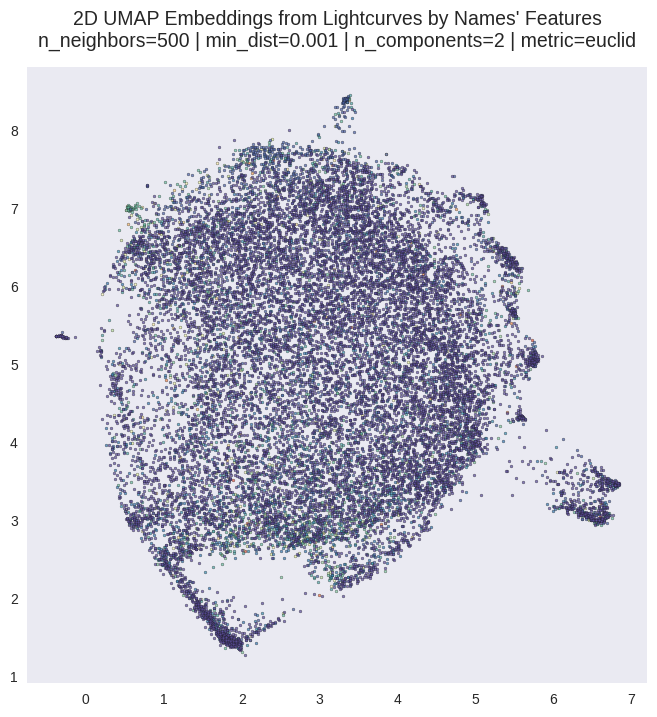

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': "2D UMAP Embeddings from Lightcurves by Names' Features\nn_neighbors=500 | min_dist=0.001 | n_components=2 | metric=euclid"}>)

<Figure size 800x550 with 0 Axes>

In [58]:
data_u = return_embedding(data, **umap_params)
plot_clusters(data_u, labels=data_df['type'], title="2D UMAP Embeddings from Lightcurves by Names' Features", display_found_clusters=False, parameters=umap_params)

/tmp/ipykernel_19617/3585150417.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(*uniqie_label_X_u.T, s=s, c=c, marker=marker, edgecolors="k", alpha=0.7)
/tmp/ipykernel_19617/3585150417.py:39: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = ax.scatter(*uniqie_label_X_u.T, s=s, c=c, marker=marker, edgecolors="k", alpha=0.7)


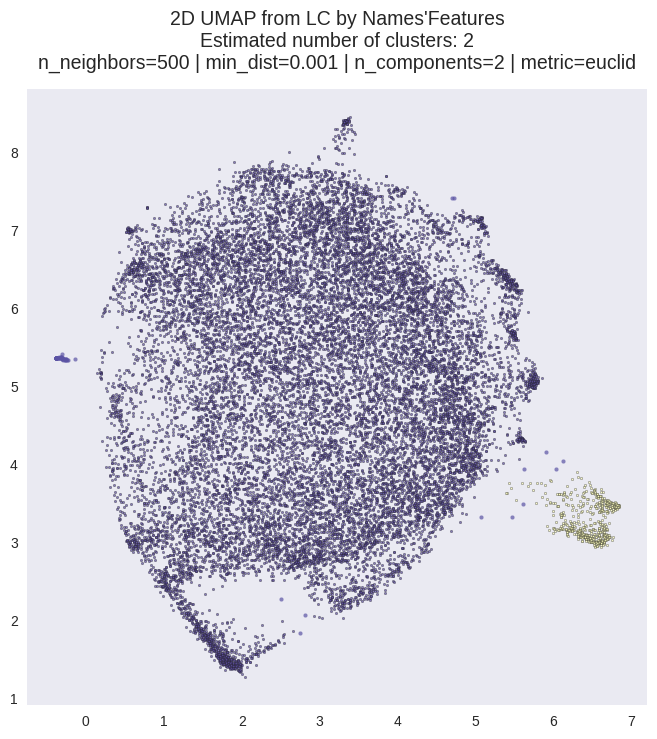

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': "2D UMAP from LC by Names'Features\nEstimated number of clusters: 2\nn_neighbors=500 | min_dist=0.001 | n_components=2 | metric=euclid"}>)

<Figure size 800x550 with 0 Axes>

In [64]:
hdbscan_params = {
    'min_cluster_size': 500,
    'min_samples': 5, # How conservative are you wben selecting a cluster
    'cluster_selection_epsilon': 0.1, # Clusters below this range are not split any further, avoids microclustering
}

hdb = HDBSCAN(**hdbscan_params).fit(data_u)
plot_clusters(data_u, hdb.labels_, probabilities=hdb.probabilities_, title="2D UMAP from LC by Names'Features", display_found_clusters=True, parameters=umap_params)